In [1]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import pickle
from importlib import reload
import numpy as np

In [3]:
# Load state sequence and data from the pickle file
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    loaded_train_test_val = pickle.load(file)

# Access the loaded data
# loaded_ss = loaded_data['state_sequence']
# loaded_data = loaded_data['data']

In [4]:
from final.useful import *

In [5]:
nfft = 128 # 32
labels = np.unique(loaded_train_test_val['train'].sample_labels)
# get_log_power_feature()

In [6]:
train_labels = loaded_train_test_val['train'].sample_labels
train_samples = loaded_train_test_val['train'].samples
humpback_indices = train_labels == 0
train_samples_humpback = [item for item, condition in zip(train_samples, humpback_indices) if condition]


In [7]:
def get_feature(sample, nfft):
    feat = np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))
    return feat

In [8]:
train_features_humpback = []
for sample in train_samples_humpback:
    train_features_humpback.append(get_feature(sample, nfft))

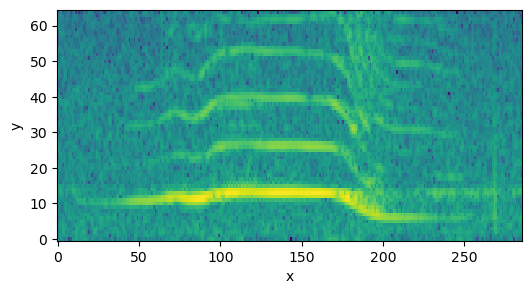

In [19]:
vis_helper(train_features_humpback[0])

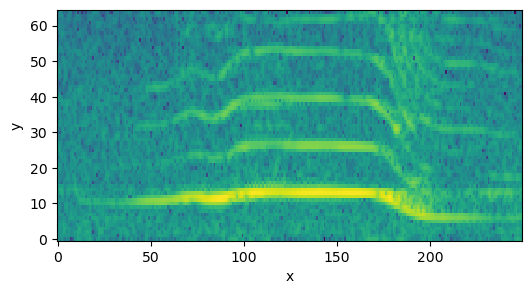

In [10]:
train_features_humpback_concat = np.concatenate(train_features_humpback)
smaller_features = train_features_humpback_concat[:250,:]
np.min(smaller_features)
vis_helper(smaller_features)

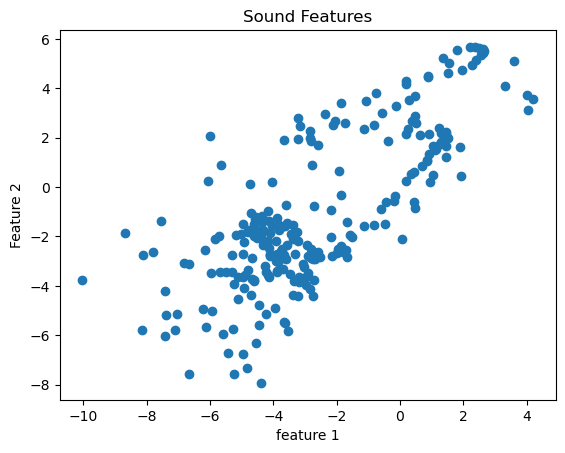

7.0750375

In [11]:
plt.scatter(smaller_features[:, 10], smaller_features[:, 11])
plt.title('Sound Features')
plt.xlabel('feature 1')
plt.ylabel('Feature 2')
plt.show()
np.var(smaller_features)

In [40]:
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmm
from final.models.hdphmm.helpers.plot_hmm import plot_hmm_data
import final.models.hdphmm.hdphmmwl.consts as const
import final.models.hdphmm.hdphmmwl.numba_wl as numba
reload(const)
reload(numba)
reload(hdphmm)

sbp = {
    const.ALPHA0: 0.2,
    const.GAMMA0: 0.2,
    const.KAPPA0: 0.2,
}
sbp[const.RHO0] = sbp[const.KAPPA0] / ( sbp[const.KAPPA0] + sbp[const.ALPHA0])
temp = 1
hdp_hmm = hdphmm.HDPHMMWL(smaller_features, 40, iterations=500, sbp=sbp)

sbp given


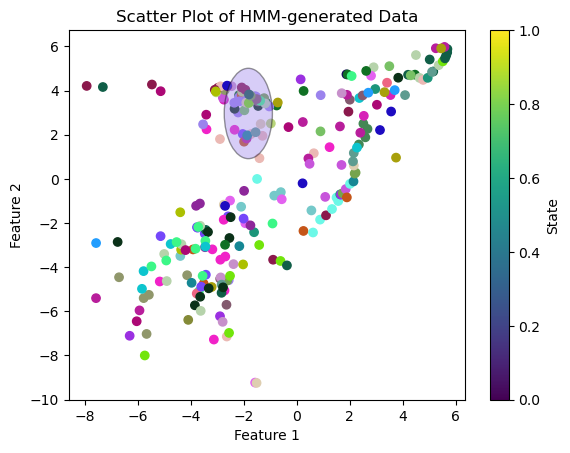

In [41]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_data(smaller_features, hdp_hmm.Z, hdp_hmm.K, hdp_hmm.mu, hdp_hmm.sigma, counts=hdp_hmm.nk, percent=5,feature_a=11, feature_b=12)
# plt.scatter(smaller_features[:, 12], smaller_features[:, 11], c=hdp_hmm.Z, cmap='viridis', marker='o')

In [42]:
hdp_hmm.fit(verbose=True)

# plt.plot(range(0,len(hdp_hmm.trace[const.TIME])), hdp_hmm.trace[const.TIME], marker="None")
# plt.xlabel('iteration')
# plt.ylabel('ARI')
# plt.xlim(0,1)
# #plt.savefig("./image/ari.png")
# plt.show()
# plt.close()
print('average time for one gibbs sweep: ', np.mean(hdp_hmm.trace[const.TIME]))

fitting using gibbs sampling
it:  0  || Likelihood:  -22445.61034087631
it:  10  || Likelihood:  -21557.81414748699
it:  20  || Likelihood:  -21444.412907257538
it:  30  || Likelihood:  -21428.91391908279
it:  40  || Likelihood:  -21484.18684538392
it:  50  || Likelihood:  -21238.53949646626
it:  60  || Likelihood:  -21215.89414382206
it:  70  || Likelihood:  -21199.606900835566
it:  80  || Likelihood:  -21161.539203158074
it:  90  || Likelihood:  -21106.73830719472
it:  100  || Likelihood:  -21181.610387588837
it:  110  || Likelihood:  -21278.797966902526
it:  120  || Likelihood:  -21103.522539840593
it:  130  || Likelihood:  -21140.94141741431
it:  140  || Likelihood:  -21410.963583450543
it:  150  || Likelihood:  -21154.64938379358
it:  160  || Likelihood:  -21101.68832889596
it:  170  || Likelihood:  -21194.0957977066
it:  180  || Likelihood:  -21127.615224792396
it:  190  || Likelihood:  -21094.886151586354
it:  200  || Likelihood:  -21144.597967542093
it:  210  || Likelihood:  -2

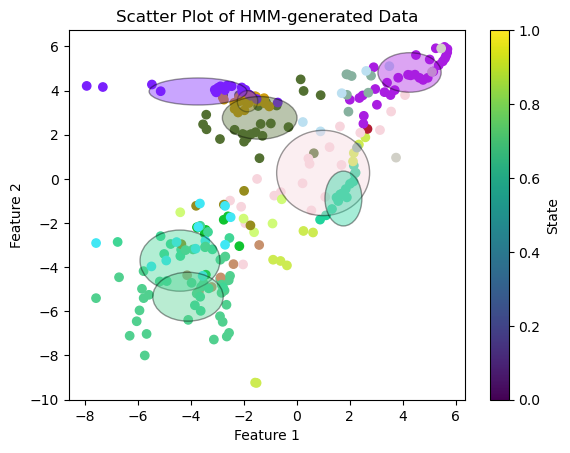

In [43]:
plot_hmm.plot_hmm_data(smaller_features, hdp_hmm.Z, hdp_hmm.K, hdp_hmm.mu, hdp_hmm.sigma, counts=hdp_hmm.nk, percent=5,feature_a=11, feature_b=12)

In [46]:
gibbs_hmm = hdp_hmm.hmm
em_hmm = GaussianHMM(10, covariance_type='diag')
em_hmm.fit(smaller_features)
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -26370.479803144364 em:  -26718.644665980133


In [47]:
gibbs_hmm.fit(smaller_features)

GaussianHMM(init_params='', n_components=18)

In [48]:
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -24635.587943985214 em:  -26718.644665980133


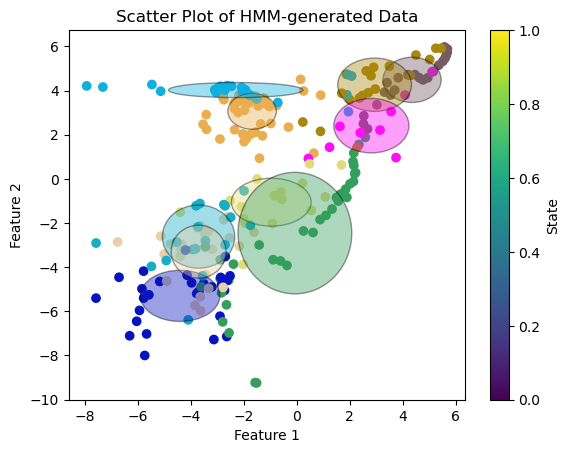

In [49]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_data(smaller_features, ss_em, em_hmm.n_components, em_hmm.means_, em_hmm.covars_, feature_a=11, feature_b=12)